# Mouse line analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from batchutils import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [3]:
analysis_type = 'main' # DEFAULT_ANALYSIS  # Analysis type
mouseline = 'pv'  # Mouse line
layer = None  # cortical layer
slack_notify = False
kalman_gain = KALMAN_GAIN  # Gain of Kalman filter
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
ykey_classification = Label.DFF  # Variable of interest for post-processing
rel_std_bounds = None  # critical relative variation factor determining valid range boundaries
ykeys_plt = [  # Plotting variables
    Label.DFF,
    # Label.ZSCORE, 
    # Label.EVENT_RATE
]   

### Derived parameters

In [4]:
# Get batch-related settings
dataset_group_id, trialavg_dir, figsdir, figs_suffix = get_batch_settings(
    analysis_type, mouseline, layer, kalman_gain, neuropil_scaling_coeff,
    baseline_quantile, baseline_wquantile, baseline_wsmoothing,
    ykey_classification)
baseline_quantile_str = 'adaptive' if baseline_quantile is None else f'{baseline_quantile:.2f}'

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_group_id} {analysis_type} analysis notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 12/12/2022 19:04:51: assembling batch analysis settings...
 12/12/2022 19:04:51: pv main analysis notebook started on 2022-12-12 at 19:04:51


### Input summary table figure

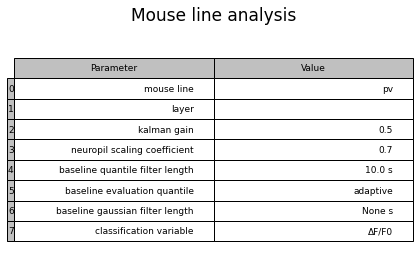

In [5]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'layer': layer,
    'kalman gain': kalman_gain,
    'neuropil scaling coefficient': neuropil_scaling_coeff,
    'baseline quantile filter length': f'{baseline_wquantile} s',
    'baseline evaluation quantile': baseline_quantile_str,
    'baseline gaussian filter length': f'{baseline_wsmoothing} s',
    'classification variable': ykey_classification
    }, title='Mouse line analysis', aspect=1.5)

### Load data

In [6]:
# Determine exclude patterns
exclude_patterns = {
    'line3': [
        '20191107_mouse1_region2',  # poor cell distribution & segmentation results
        '20191113_mouse9_region1',  # presence of many dead cells?
        '20191113_mouse9_region2',  # presence of many dead cells?
        '20190829_mouse10_region1',  # almost zero positive responder
    ],
    'celia_line3': [
        '20191023_mouse3_region1',  # only 3 conditions, suspicious cell distribution
    ],
    'sarah_line3': [
        
    ],
    'sst': [
        '20190511_mouse7_region1',  # huge dFF values at .8MPa 50%DC
        '20190513_mouse2_region1',  # huge dFF values across all DCs at .8MPa
        '20190516_mouse8_region1',  # almost zero positive responder
        '20190516_mouse8_region2',  # almost zero positive responder
        '20190706_mouse7_region1',  # huge peak at 0.1MPa
        '20190808_mouse6_region1',  # huge motion artefacts in initial run 
    ],
    'pv': [
        # '20190606_mouse2_region1',  # incomplete (no high DC data)
        # '20190606_mouse2_region2',  # incomplete (no high DC data), negative dips for positive responders
        # '20190821_mouse3_region1',  # noisy DC dependencies
        # # '20190702_mouse5_region1',  # super negative dip for P = 0.4 MPa
        # # '20190821_mouse6_region1',  # strong activations for low pressures, very noisy dFF profiles
        # # '20190630_mouse3_region1',  # super strong outlier at P = 0.4 MPa
        # # '20190821_mouse7_region1',  # super oscillatory profile
    ]
}[mouseline]

# Determine what to do in case of duplicate runs
on_duplicate_runs = 'drop'

# Load datasets
logger.info(f'loading data from {trialavg_dir}:')
data = load_trialavg_datasets(
    trialavg_dir, layer=layer,
    exclude_patterns=exclude_patterns,
    on_duplicate_runs=on_duplicate_runs)
timeseries, stats, ROI_masks, map_ops = extract_from_batch_data(data)

# Display ROI count per dataset & run, and highlight incomplete datasets
logger.info('detailed ROI count:')
get_detailed_ROI_count(stats)

 12/12/2022 19:04:52: loading data from /Users/tlemaire/Documents/data/usnm/trial-averaged/classΔFF0/alpha0.7_qadaptive_wq10.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/main/pv:
 12/12/2022 19:04:52: excluding datasets with the following patterns:

 12/12/2022 19:04:52: loading trial-averaged data from 20190606_mouse2_region1.h5
 12/12/2022 19:04:52: loading trial-averaged data from 20190606_mouse2_region2.h5
 12/12/2022 19:04:52: loading trial-averaged data from 20190629_mouse2_region1.h5
 12/12/2022 19:04:52: loading trial-averaged data from 20190630_mouse3_region1.h5
 12/12/2022 19:04:52: loading trial-averaged data from 20190702_mouse1_region1.h5
 12/12/2022 19:04:52: loading trial-averaged data from 20190702_mouse5_region1.h5
 12/12/2022 19:04:52: loading trial-averaged data from 20190703_mouse4_region1.h5
 12/12/2022 19:04:52: loading trial-averaged data from 20190821_mouse3_region1.h5
 12/12/2022 19:04:52: loading trial-averaged data from 2

### Breakdown per mouse region & cell maps

 12/12/2022 19:04:54: plotting cell maps...


10it [00:02,  3.46it/s]                      


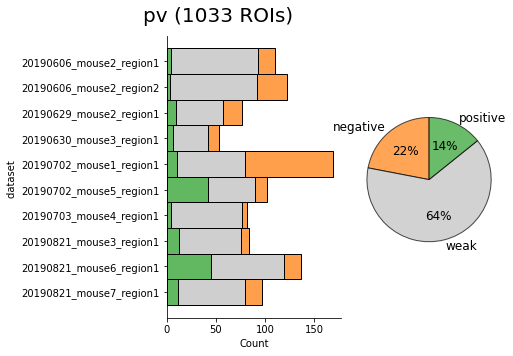

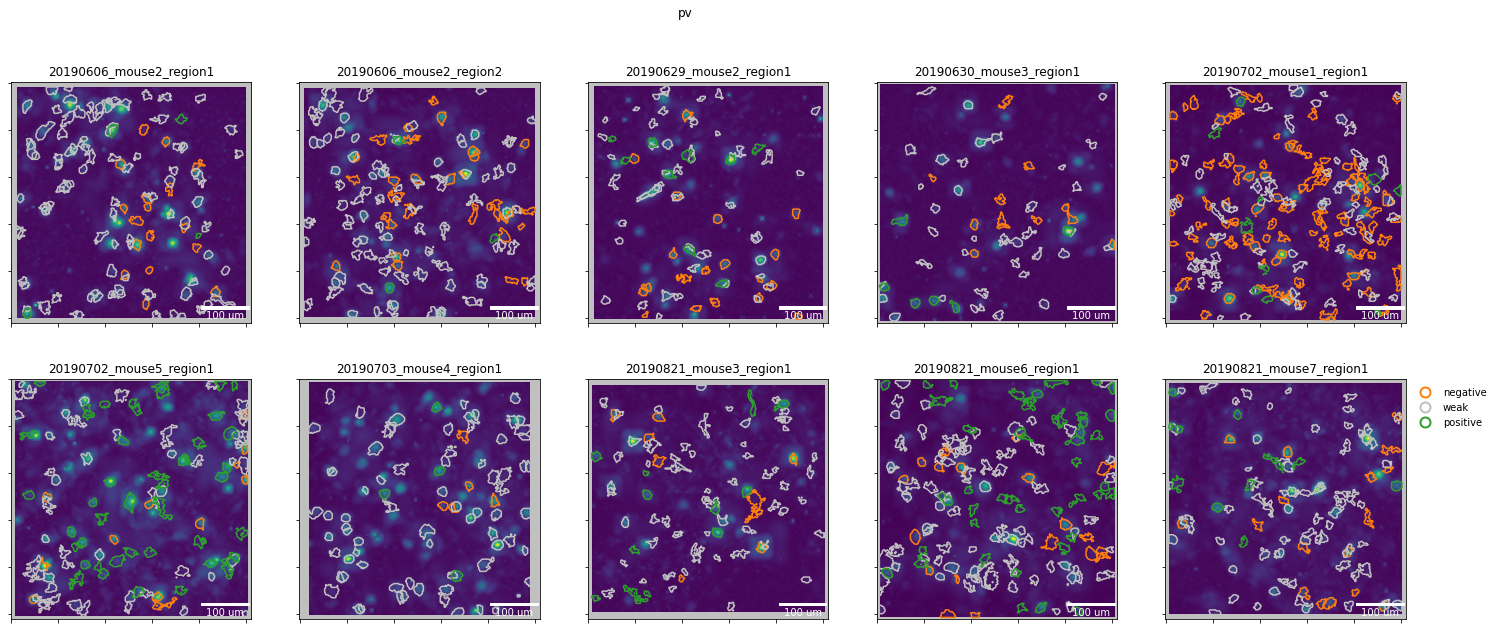

In [7]:
# Plot cell count breakdown
figs['rtype dist per mousereg'] = plot_cellcounts(
    stats, hue=Label.ROI_RESP_TYPE, title=mouseline)
# Plot cell maps
figs['cellmaps'] = plot_cell_maps(
    ROI_masks, stats, map_ops, title=mouseline, refkey='Vcorr', mode='contour')

### Optional: exclude specific datasets / data


In [8]:
if rel_std_bounds is not None:
    stats = stats.groupby(Label.RUN).apply(
        lambda d: exclude_outliers(d, get_change_key(Label.DFF), k=rel_std_bounds))
    timeseries = expand_to_match(stats, timeseries.index)

### Inspect run sequences per dataset and potential consequences on evoked activity

 12/12/2022 19:04:58: plotting I_SPTA (W/cm2) run sequence dependency across dataset...
 12/12/2022 19:04:58: run ID no part of (P (MPa), DC (%)) -> no filtering
 12/12/2022 19:04:58: sub-indexing data...
 12/12/2022 19:04:58: filtering data...
 12/12/2022 19:04:58: cross-checking filters...
 12/12/2022 19:04:58: grouping by dataset, averaging, estimating confidence intervals and plotting mean I_SPTA (W/cm2) vs. run ID ...
 12/12/2022 19:05:00: plotting evoked ΔF/F0 change run sequence dependency across dataset...
 12/12/2022 19:05:00: run ID no part of (P (MPa), DC (%)) -> no filtering
 12/12/2022 19:05:00: sub-indexing data...
 12/12/2022 19:05:00: filtering data...
 12/12/2022 19:05:00: cross-checking filters...
 12/12/2022 19:05:00: grouping by dataset, averaging, estimating confidence intervals and plotting mean evoked ΔF/F0 change vs. run ID ...
 12/12/2022 19:05:03: parameter sequences across datasets:


dataset 20190606_mouse2_region1 20190606_mouse2_region2  \
run ID                                                    
0                 0.80MPa_50%DC           0.80MPa_50%DC   
1                 0.80MPa_40%DC           0.80MPa_40%DC   
2                 0.80MPa_30%DC           0.80MPa_30%DC   
3                 0.80MPa_20%DC           0.80MPa_20%DC   
4                 0.80MPa_10%DC           0.80MPa_10%DC   
5                 0.80MPa_05%DC           0.80MPa_05%DC   
6                 0.00MPa_50%DC           0.00MPa_50%DC   
7                 0.60MPa_50%DC                     NaN   
8                 0.40MPa_50%DC                     NaN   
9                 0.20MPa_50%DC                     NaN   
10                          NaN                     NaN   
11                          NaN           0.60MPa_50%DC   
12                          NaN           0.40MPa_50%DC   
13                          NaN           0.20MPa_50%DC   
14                          NaN                     NaN   
15                          NaN                     NaN   

dataset 20190629_mouse2_region1 20190630_mouse3_region1  \
run ID                                                    
0                 0.80MPa_50%DC           0.80MPa_50%DC   
1                 0.80MPa_40%DC           0.80MPa_40%DC   
2                 0.80MPa_30%DC           0.80MPa_30%DC   
3                 0.80MPa_20%DC           0.80MPa_20%DC   
4                 0.80MPa_10%DC           0.80MPa_10%DC   
5                 0.80MPa_05%DC           0.80MPa_05%DC   
6                 0.00MPa_50%DC           0.00MPa_50%DC   
7                 0.60MPa_50%DC           0.60MPa_50%DC   
8                 0.40MPa_50%DC           0.40MPa_50%DC   
9                 0.20MPa_50%DC           0.20MPa_50%DC   
10                0.10MPa_50%DC           0.10MPa_50%DC   
11                0.80MPa_60%DC           0.05MPa_50%DC   
12                0.80MPa_70%DC           0.80MPa_60%DC   
13                0.80MPa_80%DC           0.80MPa_70%DC   
14                0.05MPa_50%DC           0.80MPa_80%DC   
15                          NaN                     NaN   

dataset 20190702_mouse1_region1 20190702_mouse5_region1  \
run ID                                                    
0                 0.80MPa_50%DC           0.80MPa_50%DC   
1                 0.80MPa_40%DC           0.80MPa_40%DC   
2                 0.80MPa_30%DC           0.80MPa_30%DC   
3                 0.80MPa_20%DC           0.80MPa_20%DC   
4                 0.80MPa_10%DC           0.80MPa_10%DC   
5                 0.80MPa_05%DC           0.80MPa_05%DC   
6                 0.00MPa_50%DC           0.00MPa_50%DC   
7                 0.60MPa_50%DC           0.60MPa_50%DC   
8                 0.40MPa_50%DC           0.40MPa_50%DC   
9                 0.20MPa_50%DC           0.20MPa_50%DC   
10                0.10MPa_50%DC           0.10MPa_50%DC   
11                0.05MPa_50%DC           0.05MPa_50%DC   
12                0.80MPa_60%DC           0.80MPa_60%DC   
13                0.80MPa_70%DC           0.80MPa_70%DC   
14                0.80MPa_80%DC           0.80MPa_80%DC   
15                          NaN                     NaN   

dataset 20190703_mouse4_region1 20190821_mouse3_region1  \
run ID                                                    
0                 0.80MPa_40%DC           0.80MPa_50%DC   
1                 0.80MPa_30%DC           0.80MPa_40%DC   
2                 0.80MPa_20%DC           0.80MPa_30%DC   
3                 0.80MPa_10%DC           0.80MPa_20%DC   
4                 0.80MPa_05%DC           0.80MPa_10%DC   
5                 0.00MPa_50%DC           0.80MPa_05%DC   
6                 0.60MPa_50%DC           0.60MPa_50%DC   
7                 0.40MPa_50%DC           0.40MPa_50%DC   
8                 0.20MPa_50%DC           0.20MPa_50%DC   
9                 0.10MPa_50%DC           0.10MPa_50%DC   
10                0.05MPa_50%DC           0.05MPa_50%DC   
11                0.80MPa_60%DC           0.

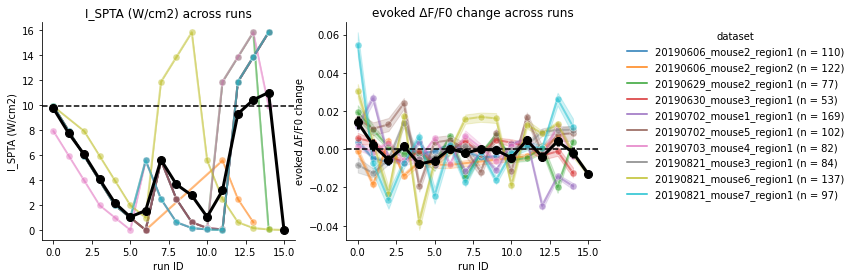

In [9]:
# Get parameter run sequence per dataset
param_seqs = stats[[Label.RUNID, Label.P, Label.DC]].groupby([Label.DATASET, Label.RUNID]).first()
param_seqs = get_param_code(param_seqs).unstack().T

# Plot Ispta and evoked DFF across run sequences, per dataset
ykeys_seq = [Label.ISPTA, get_change_key(Label.DFF)]
Ispta_ref = pressure_to_intensity(P_REF / PA_TO_MPA) / M2_TO_CM2 * DC_REF / 1e2
figs['rundeps_global'], axes = plt.subplots(
    1, len(ykeys_seq), figsize=(5 * len(ykeys_seq), 4))
axes = np.atleast_1d(axes)
for i, (ykey, ax) in enumerate(zip(ykeys_seq, axes)):
    # Plot run sequence dependencies across datasets
    logger.info(f'plotting {ykey} run sequence dependency across dataset...')
    plot_parameter_dependency(
        stats, xkey=Label.RUNID, ykey=ykey,
        yref=Ispta_ref if ykey == Label.ISPTA else 0., 
        hue=Label.DATASET, avgprop='whue', errprop='intra', ax=ax,
        legend=i == len(ykeys_seq) - 1, title=f'{ykey} across runs')

logger.info('parameter sequences across datasets:')
param_seqs

### Plot pressure and DC dependency curves

 12/12/2022 19:05:03: plotting ΔF/F0 stimulation parameters dependencies for negative responders...
 12/12/2022 19:05:03: plotting ΔF/F0 stimulation parameters dependencies for positive responders...
 12/12/2022 19:05:03: plotting ΔF/F0 stimulation parameters dependencies for weak responders...
 12/12/2022 19:05:03: plotting ΔF/F0 stimulation parameters dependencies across responders...


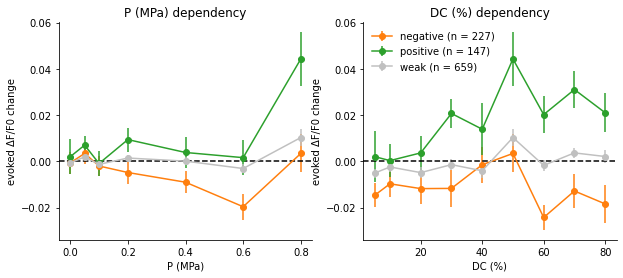

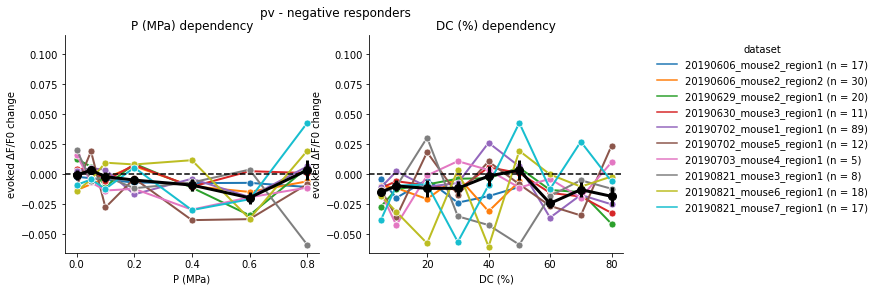

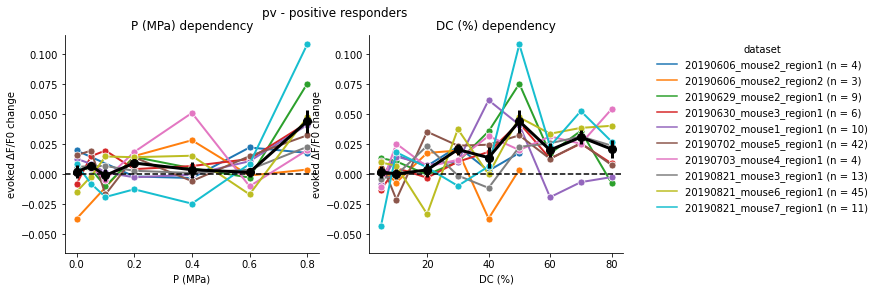

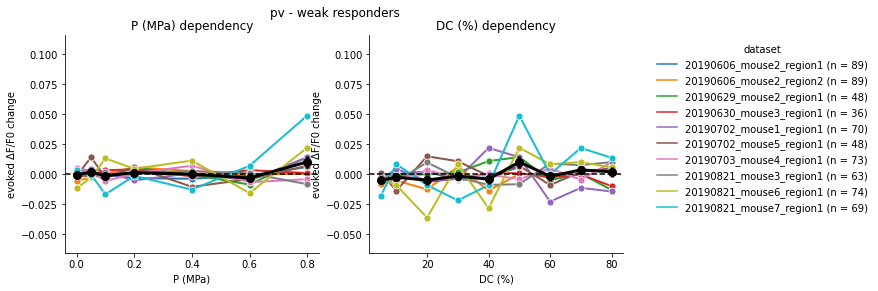

In [10]:
figs['stimparamdeps_global'], axes = plt.subplots(
    len(ykeys_plt), 2, figsize=(10, len(ykeys_plt) * 4))
axes = np.atleast_2d(axes)
fit = False
for ykey, axrow in zip(ykeys_plt, axes):
    # Determine output metrics key
    ykey_diff = get_change_key(ykey)

    # Plot param dependencies across datasets for each responder type separately
    tmpaxes = []
    for rtype, substats in stats.groupby(Label.ROI_RESP_TYPE):
        figkey = f'{ykey}_stimparamdeps_{rtype}'
        logger.info(f'plotting {ykey} stimulation parameters dependencies for {rtype} responders...')
        logger.setLevel(logging.WARNING)
        figs[figkey] = plot_stimparams_dependency(
            substats, ykey_diff, yref=0, hue=Label.DATASET, 
            avgprop='whue', errprop='inter',
            hue_alpha=1.,
            # lw=0,
            ci=None,
            fit=fit, 
        )
        figs[figkey].suptitle(f'{mouseline} - {rtype} responders')
        tmpaxes = tmpaxes + figs[figkey].axes
        logger.setLevel(logging.INFO)
    harmonize_axes_limits(np.asarray(tmpaxes))

    # Plot dependencies on each parameter on separate axes
    logger.info(f'plotting {ykey} stimulation parameters dependencies across responders...')
    plot_stimparams_dependency(
        stats, 
        ykey=ykey_diff, yref=0., 
        hue=Label.ROI_RESP_TYPE, 
        axes=axrow,
        weighted=True,
        fit=fit,
    )
for axrow in axes[1:]:
    for ax in axrow:
        ax.set_title(None)
for axrow in axes[:-1]:
    for ax in axrow:
        ax.set_xlabel(None)

### Plot intensity dependency curves

In [11]:
figs['ispta_deps'], axes = plt.subplots(1, len(ykeys_plt), figsize=(len(ykeys_plt) * 4, 4))
axes = np.atleast_1d(axes)
figs['ispta_deps'].suptitle(f'ISPTA dependencies')
for ykey, ax in zip(ykeys_plt, axes):
    plot_intensity_dependencies(stats, get_change_key(ykey), ax=ax)
figs['ispta_deps'].tight_layout()

 12/12/2022 19:05:04: plotting evoked ΔF/F0 change ISPTA dependency across responders...


### Plot trial heatmap per condition for entire mouse line

 12/12/2022 19:05:05: 20190606_mouse2_region1: expanding 109300-rows series into 110 ROIs x 15 runs x 100 frames (165000-rows) series (55700 additional rows)
 12/12/2022 19:05:05: 20190606_mouse2_region2: expanding 122000-rows series into 122 ROIs x 15 runs x 100 frames (183000-rows) series (61000 additional rows)
 12/12/2022 19:05:06: 20190629_mouse2_region1: original 115500-rows series is alreay rectilinear -> ignoring
 12/12/2022 19:05:06: 20190630_mouse3_region1: original 79500-rows series is alreay rectilinear -> ignoring
 12/12/2022 19:05:06: 20190702_mouse1_region1: expanding 253100-rows series into 169 ROIs x 15 runs x 100 frames (253500-rows) series (400 additional rows)
 12/12/2022 19:05:07: 20190702_mouse5_region1: expanding 152700-rows series into 102 ROIs x 15 runs x 100 frames (153000-rows) series (300 additional rows)
 12/12/2022 19:05:08: 20190703_mouse4_region1: expanding 122800-rows series into 82 ROIs x 15 runs x 100 frames (123000-rows) series (200 additional rows)


15it [00:08,  1.79it/s]                        


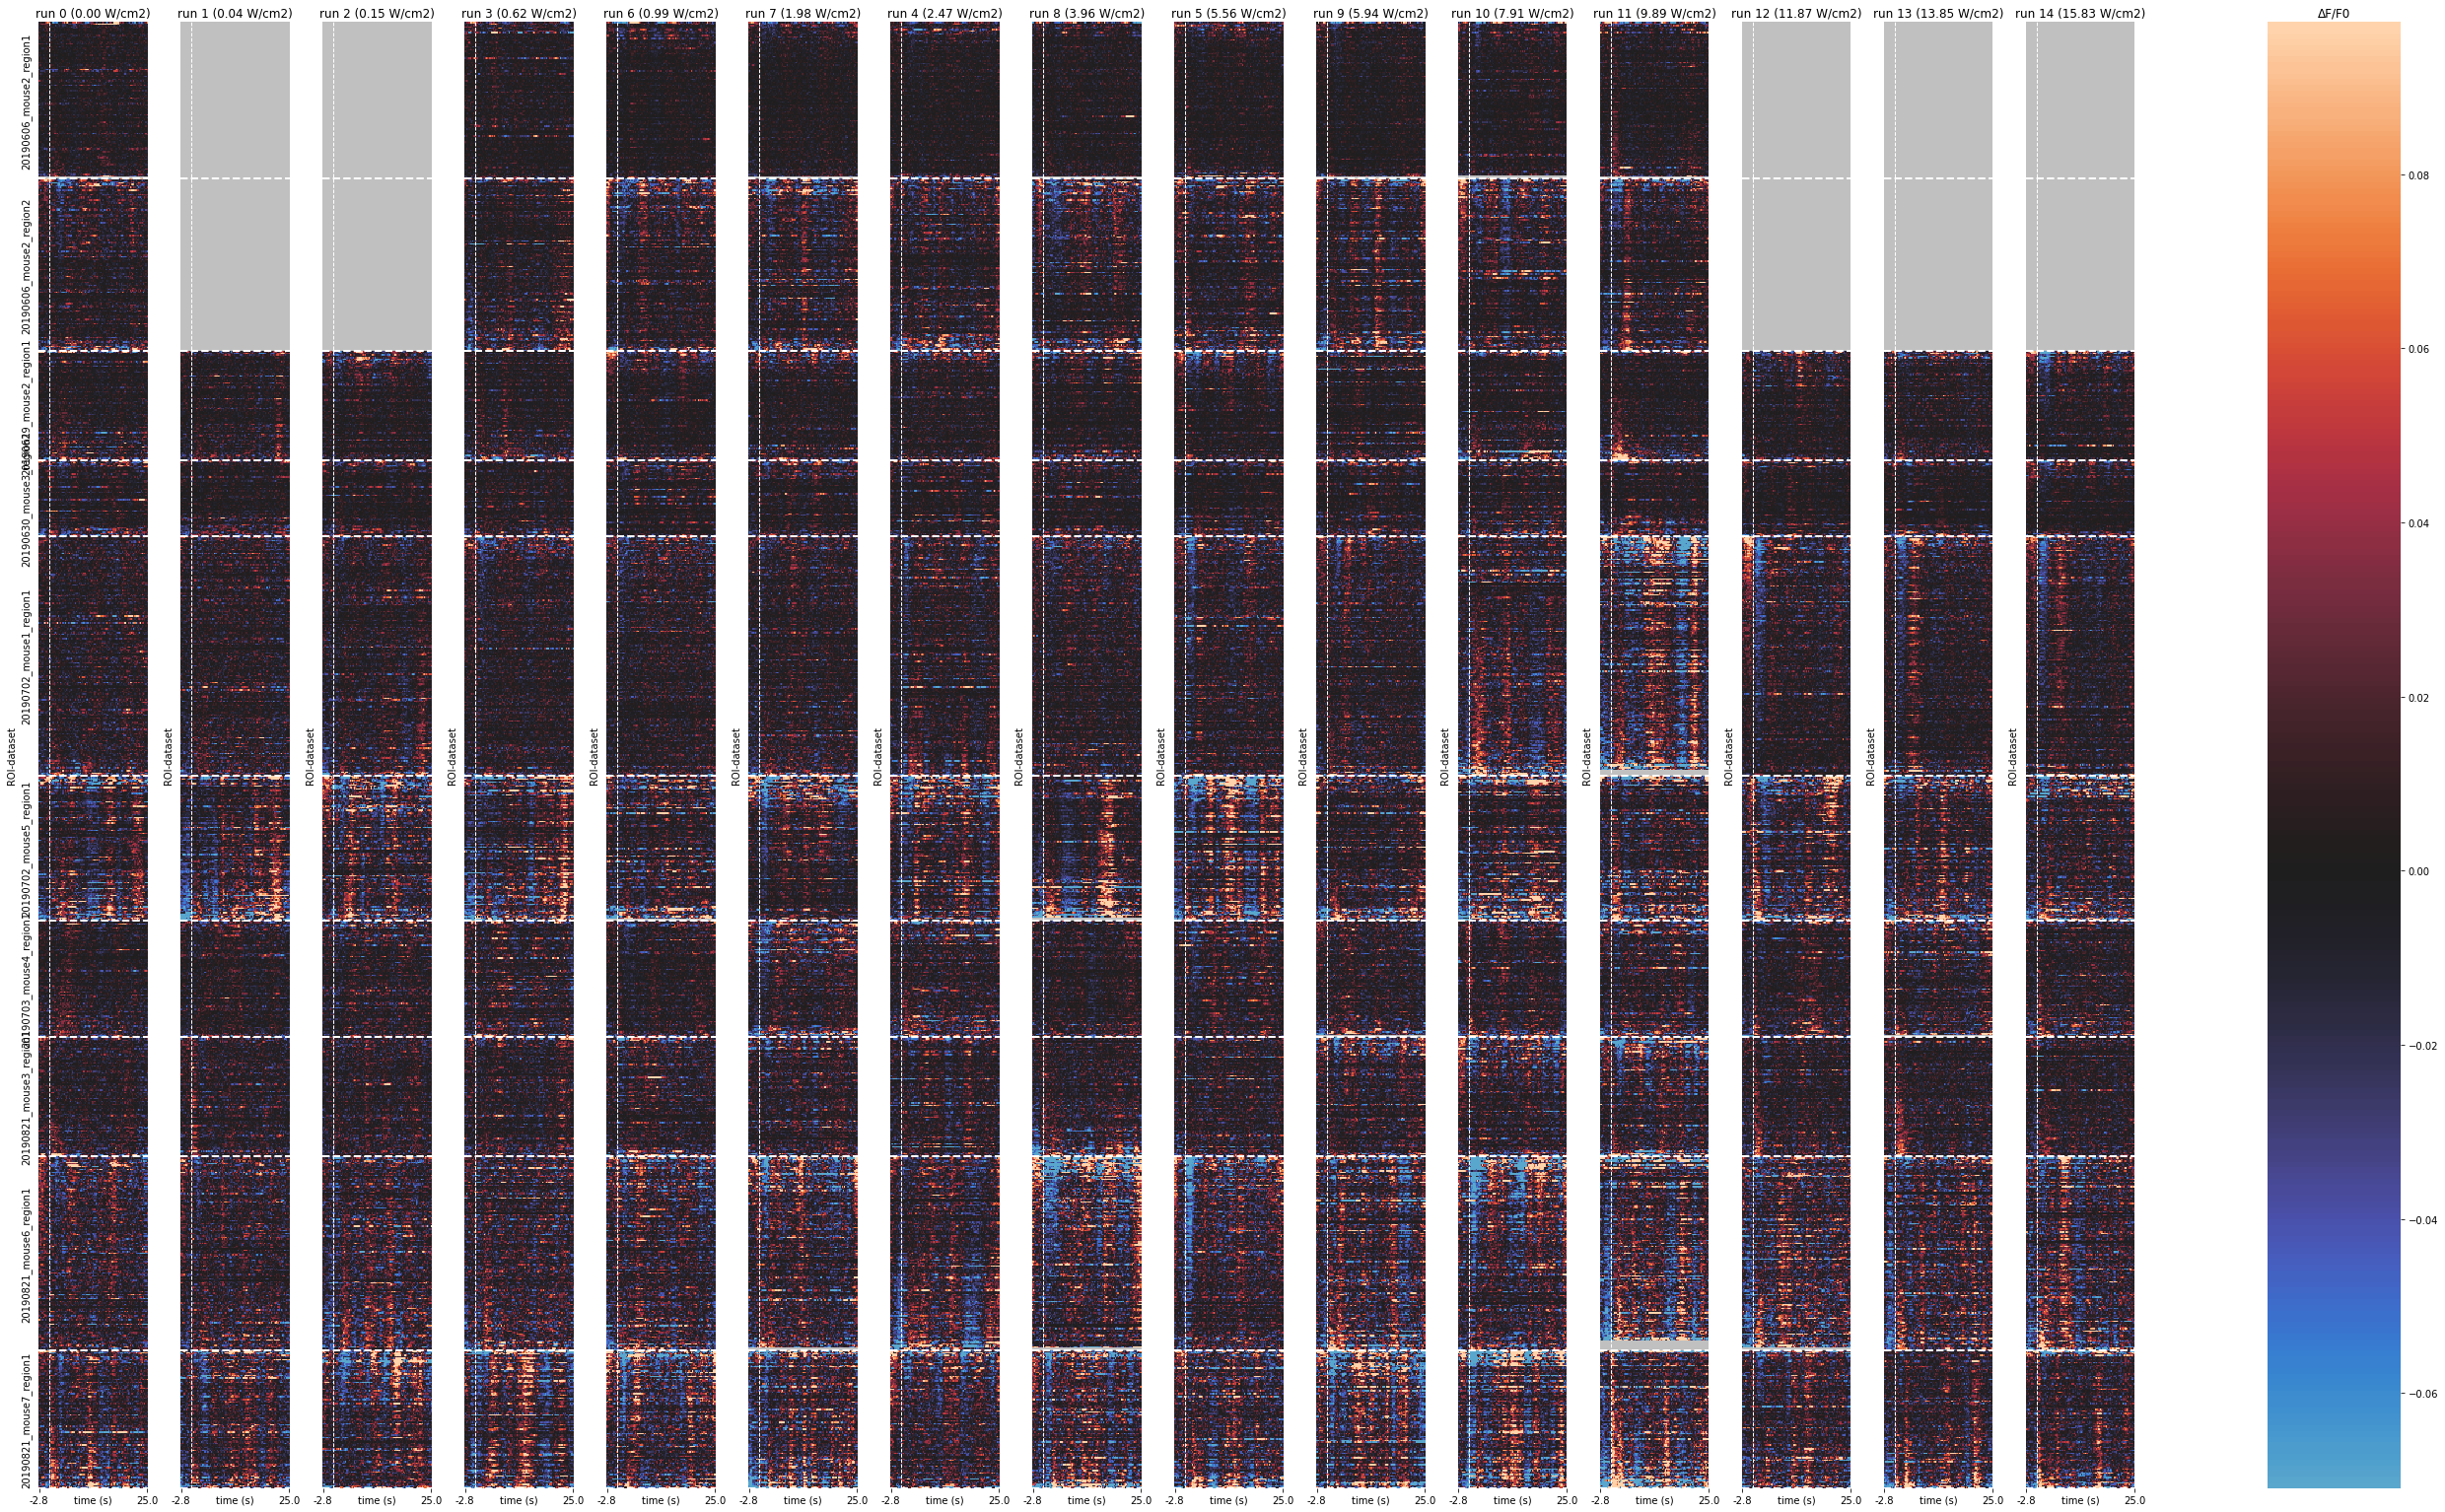

In [12]:
# # Get proportion of each response type per condition and dataset
# respcounts = stats[Label.RESP_TYPE].groupby([Label.DATASET, Label.RUN]).value_counts()
# totcounts = respcounts.groupby([Label.DATASET, Label.RUN]).sum()
# respprops = respcounts / totcounts
# respprops = respprops.unstack().fillna(0)
# # Get datasets & conditions yelding high proportions of positive and negative responders
# negresps = respprops[respprops['negative'] >= 0.5]['negative'].sort_values(ascending=False).to_frame()
# negresps['color'] = Palette.RTYPE['negative']
# posresps = respprops[respprops['positive'] >=0.5]['positive'].sort_values(ascending=False).to_frame()
# posresps['color'] = Palette.RTYPE['positive']
# extreme_conds = pd.concat([negresps, posresps], axis=0)
# rect_markers = extreme_conds['color']
rect_markers = None

sorted_ISPTAs = stats[Label.ISPTA].groupby(Label.RUN).first().sort_values().apply(
    '{:.2f} W/cm2'.format)
fps = get_singleton(stats, Label.FPS)
for ykey in ykeys_plt:
    figs[f'{ykey} heatmap'] = plot_trial_heatmap(
        timeseries, ykey, fps, col=Label.RUN,
        col_order=sorted_ISPTAs.index.values, 
        col_labels=sorted_ISPTAs.values,
        rasterized=True,
        colwrap=len(sorted_ISPTAs), 
        sort_ROIs=True,
        rect_markers=rect_markers
    )

### Plot response traces

 12/12/2022 19:05:20: merging timeseries and stats information...
 12/12/2022 19:05:24: adding time info to table...
 12/12/2022 19:05:25: plotting P (MPa) dependency curves for negative responders...
 12/12/2022 19:05:25: sub-indexing data...
 12/12/2022 19:05:25: filtering data...
 12/12/2022 19:05:25: cross-checking filters...
 12/12/2022 19:05:25: grouping by dataset, grouping by P (MPa), averaging and plotting mean ΔF/F0 vs. time (s) ...
 12/12/2022 19:05:27: plotting P (MPa) dependency curves for positive responders...
 12/12/2022 19:05:27: sub-indexing data...
 12/12/2022 19:05:27: filtering data...
 12/12/2022 19:05:27: cross-checking filters...
 12/12/2022 19:05:27: grouping by dataset, grouping by P (MPa), averaging and plotting mean ΔF/F0 vs. time (s) ...
 12/12/2022 19:05:28: plotting P (MPa) dependency curves for weak responders...
 12/12/2022 19:05:29: sub-indexing data...
 12/12/2022 19:05:29: filtering data...
 12/12/2022 19:05:29: cross-checking filters...
 12/12/2022 

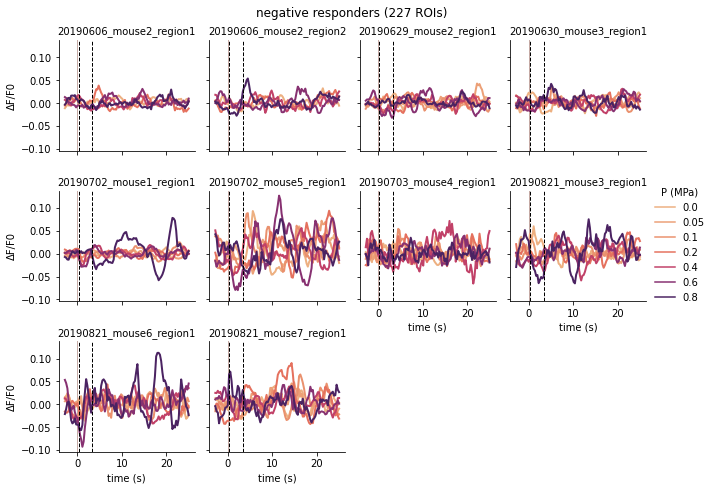

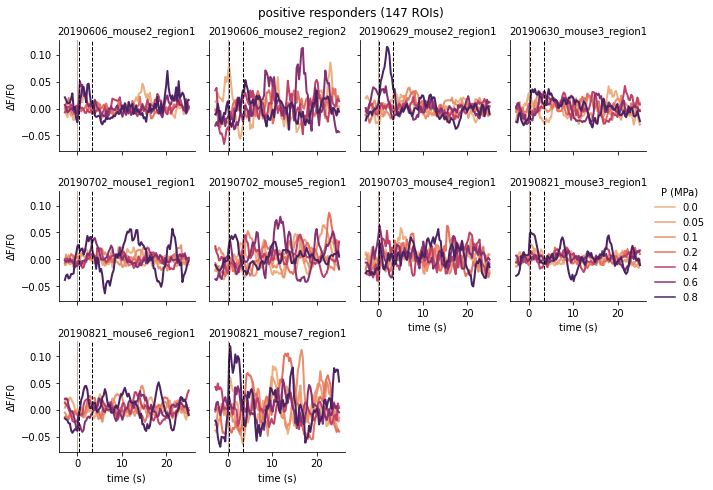

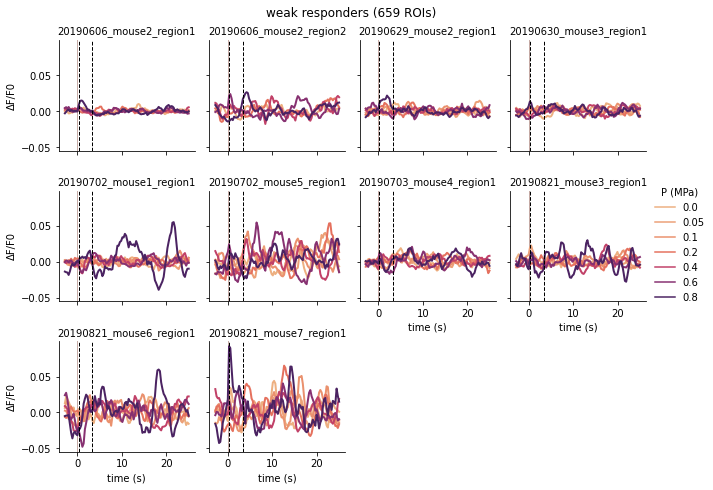

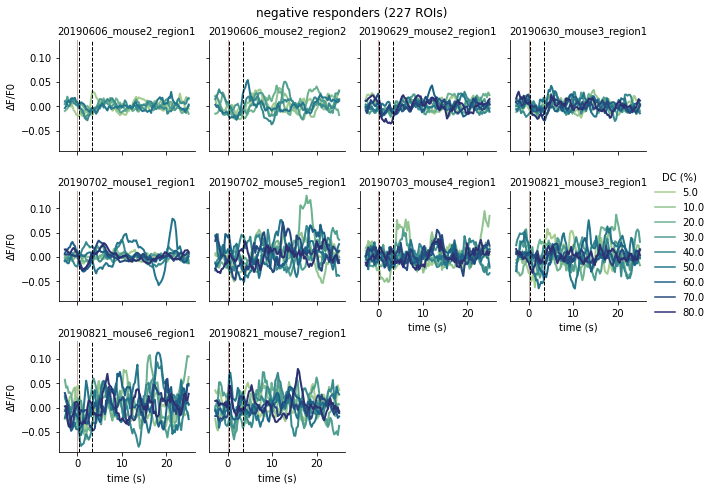

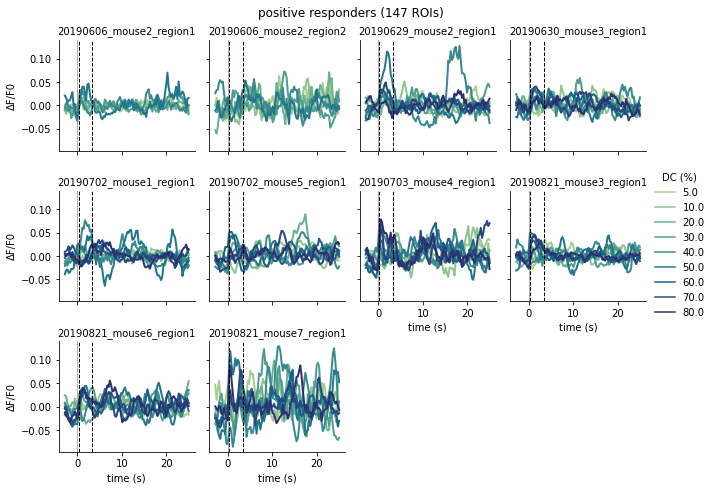

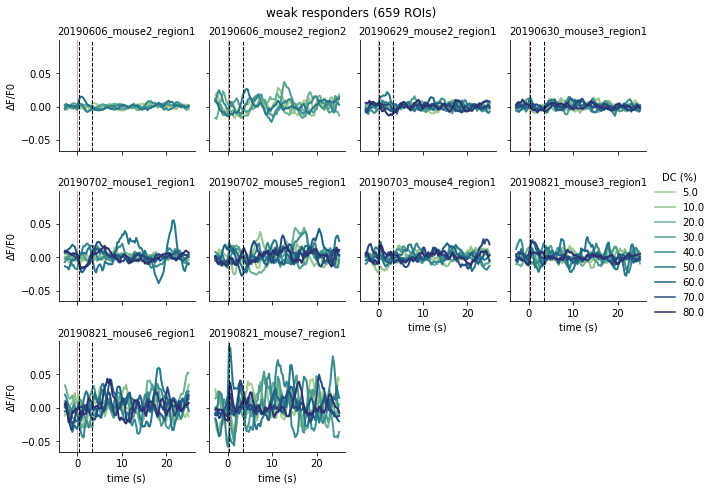

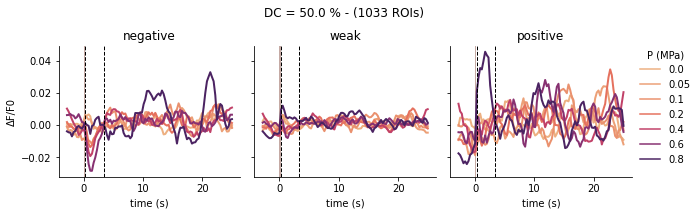

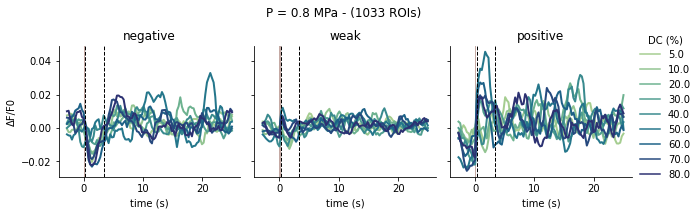

In [13]:
# Get plot-ready traces dataset
plt_data = get_plot_data(timeseries, stats)

# # Align DFF and z-score traces w.r.t their stimulus onset value
# plt_data.loc[:, [Label.DFF, Label.ZSCORE]] = align_at(
#     plt_data[[Label.DFF, Label.ZSCORE]], FrameIndex.STIM)

# Get onset slice
mux_slice = slice_last_dim(plt_data.index, FrameIndex.STIM)

# For each output variable
for ykey in ykeys_plt:

    # Pressure-dependent response traces, per dataset
    figs.update(
        plot_responses_across_datasets(plt_data, ykey=ykey, pkey=Label.P))
    # DC-dependent response traces, per dataset
    figs.update(
        plot_responses_across_datasets(plt_data, ykey=ykey, pkey=Label.DC))

    # Global (weighted) response curves for both input stimulation parameters  
    for pkey in [Label.P, Label.DC]:
        figs[f'{ykey} vs. {pkey} by type'] = plot_responses_across_datasets(
            plt_data, ykey=ykey, pkey=pkey, avg=True)

### Save responder-type-averaged stats to disk

In [14]:
rtypeavg_dir = get_output_equivalent(
    os.path.split(trialavg_dir)[0], 'trial-averaged', 'rtype-averaged')
fpath = os.path.join(rtypeavg_dir, f'{mouseline}.csv')
stats_per_rtype = get_crossdataset_average(stats, Label.RUN, hue=Label.ROI_RESP_TYPE)
logger.info(f'saving responder-type-averaged stats to {fpath}...')
stats_per_rtype.to_csv(fpath)

 12/12/2022 19:05:54: saving responder-type-averaged stats to /Users/tlemaire/Documents/data/usnm/rtype-averaged/classΔFF0/alpha0.7_qadaptive_wq10.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/main/pv.csv...


### Save figures

In [15]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 12/12/2022 19:05:54: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2022.12.12/figs_main_pv_k0.5_alpha0.7_qadaptive_wq10.0s_classΔFF0.pdf:


100%|██████████| 18/18 [00:05<00:00,  3.23it/s]


### Notify upon completion

In [16]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseline} batch notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 12/12/2022 19:06:00: pv batch notebook completed in 0:01:08.570899 s
